In [218]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import warnings

In [219]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [220]:
df_edges = pd.read_csv('data/FR_edges.csv')       # Edges
df_nodes = pd.read_csv('data/FR_target.csv')      # Nodes
print(df_edges.head())
print(df_nodes.head())

   from    to
0     0  6420
1     0  2941
2     0  3051
3     0  5511
4     0  1020
          id  days  mature  views  partner  new_id
0  150417538   577    True    775    False    4867
1  125723704   861    True   2585    False    3692
2  155971814   523   False   1566    False    3816
3   35832890  2234   False   9713    False     416
4   46787750  1896    True  44529    False    4502


In [221]:
new_id_to_id = {row['new_id']: row['id'] for _, row in df_nodes.iterrows()}

In [222]:
G = nx.Graph()
for index, row in df_edges.iterrows():
    G.add_edge(row["from"], row["to"])
for index, row in df_nodes.iterrows():
    G.nodes(row['new_id'])
G.number_of_nodes(), G.number_of_edges()

(6549, 112666)

<Axes: xlabel='mature'>

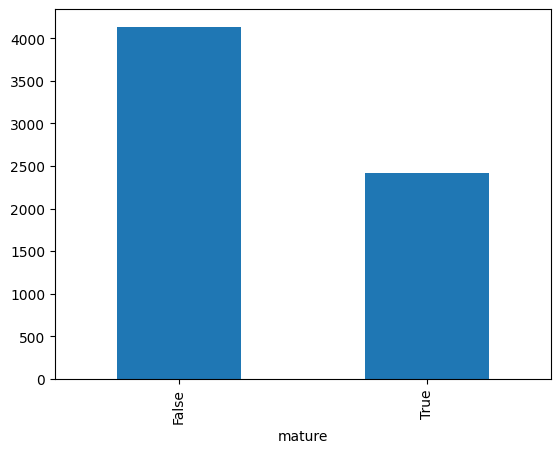

In [223]:
df_nodes['mature'].value_counts().plot(kind='bar')

In [224]:
X_train, X_test, y_train, y_test = train_test_split(df_nodes.drop(columns=["mature", "id", "new_id"]), df_nodes["mature"], test_size=0.2, random_state=42)

In [225]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5995423340961098

In [226]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.623951182303585

In [227]:
def count_n_mature_neighbors(node):
    neigbors = G.neighbors(node)
    n_mature_neighbors = 0
    for neighbor in neigbors:
        if df_nodes[df_nodes['new_id'] == neighbor]['mature'].values[0] == True:
            n_mature_neighbors += 1
    return n_mature_neighbors / G.degree(node) if G.degree(node) != 0 else 0

def mean_neigbors_views(node):
    neigbors = G.neighbors(node)
    neighbors_views = 0
    for neighbor in neigbors:
       neighbors_views += df_nodes[df_nodes['new_id'] == neighbor]['views'].values[0]
    return neighbors_views / G.degree(node) if G.degree(node) != 0 else 0

n_mature_neighbors = []
for node in df_nodes['new_id']:
    n_mature_neighbors.append(count_n_mature_neighbors(node))

mean_neighbors_views = []
for node in df_nodes['new_id']:
    mean_neighbors_views.append(mean_neigbors_views(node))

df_nodes['n_mature_neighbors'] = n_mature_neighbors
df_nodes['mean_neighbors_views'] = mean_neighbors_views

In [228]:
centrality_betweeness = nx.betweenness_centrality(G)

In [229]:
betweeness_centrality = []
for node in df_nodes['new_id']:
    betweeness_centrality.append(centrality_betweeness[node] * 1e6)

df_nodes['betweeness_centrality'] = betweeness_centrality
df_nodes.head()

,id,days,mature,views,partner,new_id,n_mature_neighbors,mean_neighbors_views,betweeness_centrality
0,150417538,577,True,775,False,4867,0.222222,7.576647e+06,2.229769
1,125723704,861,True,2585,False,3692,0.538462,7.679728e+06,11.248500
2,155971814,523,False,1566,False,3816,0.120000,1.584582e+06,26.290612
3,35832890,2234,False,9713,False,416,0.285714,3.159627e+06,49.541792
4,46787750,1896,True,44529,False,4502,0.633333,2.427530e+06,135.582284


In [230]:
X_train, X_test, y_train, y_test = train_test_split(df_nodes.drop(columns=["mature", "id", "new_id"]), df_nodes["mature"], test_size=0.2, random_state=42)

In [231]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6605644546147978

In [232]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.623951182303585

<Axes: >

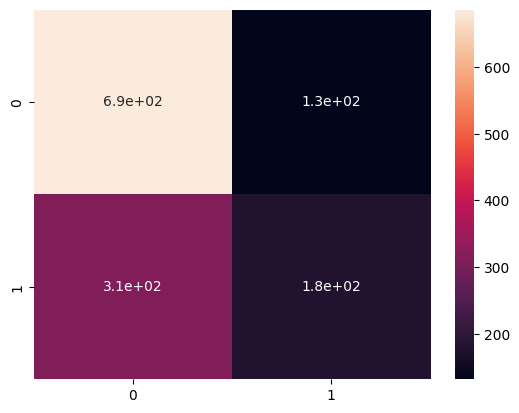

In [233]:
cm = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(cm, annot=True)

Text(0.5, 1.0, 'ROC curve')

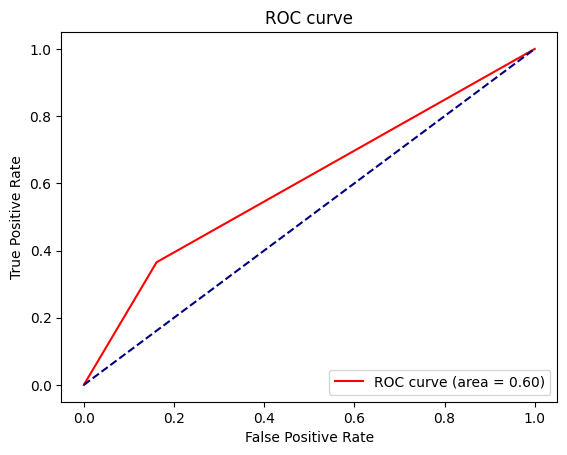

In [234]:
plt.figure()
fpr, tpr, _ = roc_curve(y_test, clf.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve')

In [235]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.69      0.84      0.76       818
        True       0.58      0.37      0.45       493

    accuracy                           0.66      1311
   macro avg       0.63      0.60      0.60      1311
weighted avg       0.65      0.66      0.64      1311



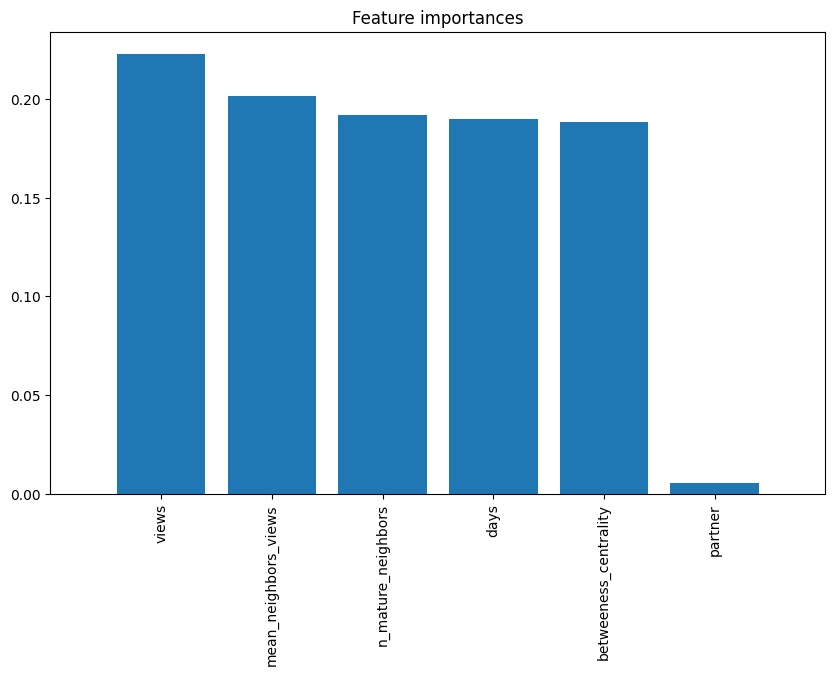

In [236]:
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [237]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_leaf': [1, 2, 4, 6],
    'min_samples_split': [2, 5, 10],
    "random_state": [42, 66, 77, 80, 99]
    }

grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_iter=100, cv=3, random_state=42, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'random_state': 42, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}
0.6772893607172105


In [238]:
params = grid_search.best_params_
clf = RandomForestClassifier(n_estimators=params["n_estimators"], max_depth=params["max_depth"], min_samples_leaf=params["min_samples_leaf"], min_samples_split=params["min_samples_split"], random_state=params["random_state"])
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6773455377574371

<Axes: >

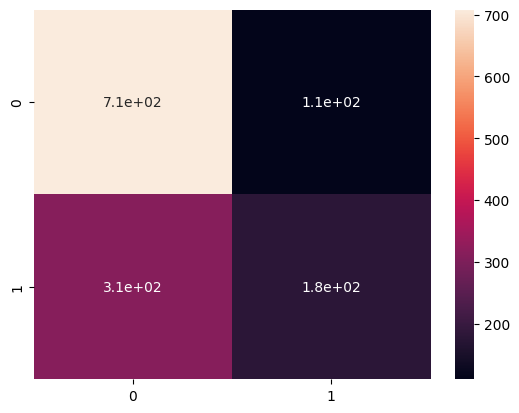

In [239]:
cm = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(cm, annot=True)

Text(0.5, 1.0, 'ROC curve')

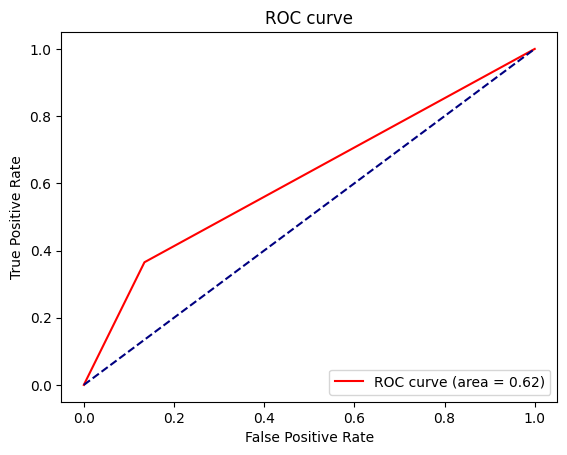

In [240]:

plt.figure()
fpr, tpr, _ = roc_curve(y_test, clf.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve')

In [241]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.69      0.87      0.77       818
        True       0.62      0.37      0.46       493

    accuracy                           0.68      1311
   macro avg       0.66      0.62      0.61      1311
weighted avg       0.67      0.68      0.65      1311



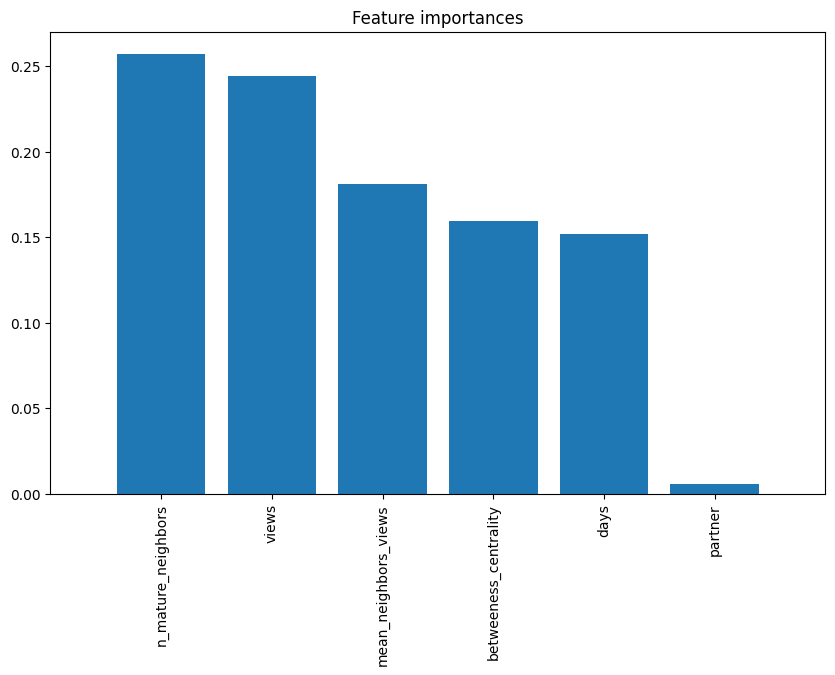

In [242]:
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()